# Model Incident Occurrence in Elderly Care Facilities

# *** Ran out of time -- happy to discuss thoughts I had for improvement later. I have many ***

## Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, auc, RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = 600

## Get Data

In [2]:
fynn = pd.read_csv(
    "/Users/brandonmurphy/Downloads/fynn_take_home/resident_care_interactions.csv"
)
# Rather than dropping NaN values... I want to include them in the model to see
# if there is value in the 'missing' level. With more time I would explore why
# the features are missing in more depth (MCAR, MNAR, etc...)
fynn = fynn.fillna("Missing")

### Helpers

In [3]:
##################
# This drops all incidents so I can't do this, even though I feel it is a correct move
##################

# def remove_non_integer_ratings(df: pd.DataFrame, remove_cols=list[str]):
#     """
#     Would fill all of these with docstrings with more time
#     """
#     remove_at_end = []

#     for col in remove_cols:
#         df[f"drop_ind_{col}"] = np.where(df[col].isin([-1, 0, 1]), 0, 1)
#         df = df[df[f"drop_ind_{col}"] == 0].copy()
#         remove_at_end.append(f"drop_ind_{col}")

#     df.drop(remove_at_end, axis=1, inplace=True)

#     return df

In [4]:
# Would put this in a config file
ohe_columns = [
    # "interaction_category", ***Target Leakage***
    # "interaction_type", *** Target Leakage ***
    "gender",
    "marital_status",
    "oxygen_required",
    "care_type_name",
    "do_not_resuscitate",
    "agitated_vs_calm",
    "isolated_vs_sociable",
    "combative_vs_agreeable",
    "confused_vs_clear",
    "confused_vs_clear",
]

### Treat Data

In [5]:
### Create Target
fynn["model_target"] = np.where(fynn["interaction_category"] == "INCIDENT", 1, 0)

In [6]:
### Remove non-integer subjective ratings
# fynn = remove_non_integer_ratings(
#     fynn,
#     remove_cols=[
#         "agitated_vs_calm",
#         "combative_vs_agreeable",
#         "confused_vs_clear",
#         "confused_vs_clear",
#     ],
# )

In [7]:
X = fynn.iloc[:, :-1].copy()
y = fynn["model_target"].copy()

#### Train / Test / Holdout
- Train = 60%
- Test = 20%
- Val = 20%

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=37
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=37
)

### Create Features

In [9]:
### This is the wrong way to fit dummies. It should be trained on the train set,
###  then applied to test and validation sets later
X_train = pd.get_dummies(X_train, columns=ohe_columns)

### Instantiate Model

In [10]:
feature_set = X_train.columns.drop(
    [
        "resident_uuid",
        "staff_member_uuid",
        "interaction_timestamp",
        "interaction_category",
        "interaction_type",
    ]
)

In [11]:
clf = LogisticRegression().fit(X_train[feature_set], y_train)

### Initial Evaluation

In [12]:
predictions = clf.predict(X_train[feature_set])

#### ROC Curve

In [14]:
print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186947
           1       1.00      0.69      0.82       202

    accuracy                           1.00    187149
   macro avg       1.00      0.84      0.91    187149
weighted avg       1.00      1.00      1.00    187149



### AUC

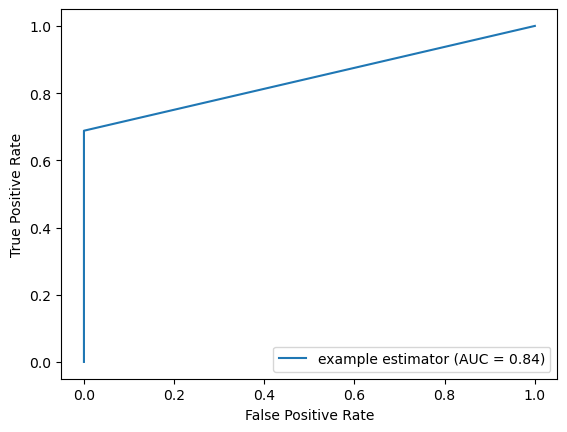

In [22]:
fpr, tpr, thresholds = roc_curve(y_train, predictions)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="example estimator"
)
display.plot()

### Grid Search 

In [36]:
parameters = {
    "solver": ["liblinear", "saga"],
    "penalty": ["l1", "l2"],
    "C": np.logspace(-4, 4, 10),
    "max_iter": [1000]
}

gs_clf = GridSearchCV(clf, parameters, cv=5, n_jobs=-1)

In [37]:
gs_clf = gs_clf.fit(X_train[feature_set], y_train)

/opt/anaconda3/envs/panic/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/panic/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/panic/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/panic/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/panic/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [38]:
print(gs_clf.best_score_)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

0.9996633703422108
C: 0.046415888336127774
max_iter: 1000
penalty: 'l1'
solver: 'liblinear'


In [39]:
pd.DataFrame(gs_clf.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,15.629013,1.178411,0.020128,0.010159,0.359381,1000,l2,saga,"{'C': 0.3593813663804626, 'max_iter': 1000, 'p...",0.999733,0.999653,0.999573,0.999599,0.99976,0.999663,0.000073,1
22,0.499376,0.118056,0.008201,0.003737,2.782559,1000,l2,liblinear,"{'C': 2.782559402207126, 'max_iter': 1000, 'pe...",0.999733,0.999653,0.999573,0.999599,0.99976,0.999663,0.000073,1
23,45.615621,1.711167,0.022033,0.008003,2.782559,1000,l2,saga,"{'C': 2.782559402207126, 'max_iter': 1000, 'pe...",0.999733,0.999653,0.999573,0.999599,0.99976,0.999663,0.000073,1
24,18.878732,2.154179,0.014323,0.003695,21.544347,1000,l1,liblinear,"{'C': 21.54434690031882, 'max_iter': 1000, 'pe...",0.999733,0.999653,0.999573,0.999599,0.99976,0.999663,0.000073,1
25,130.595824,10.221535,0.011605,0.002048,21.544347,1000,l1,saga,"{'C': 21.54434690031882, 'max_iter': 1000, 'pe...",0.999733,0.999653,0.999573,0.999599,0.99976,0.999663,0.000073,1


### Train Model w/ Best Params

### Evaluate Final Model